In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import cv2
import os
import dlib

from google.colab.patches import cv2_imshow
import numpy as np
import json
import pandas as pd
import csv

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.models import Sequential
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from keras.optimizers import Adam

In [ ]:

n_frames = 1


root = './drive/MyDrive/dataset/'
train_dir_path = './drive/MyDrive/dataset/train_sample_videos/'
test_dir_path = './drive/MyDrive/dataset/test_videos/'

frame_path = './drive/MyDrive/dataset/frames/'
test_frames_path =  './drive/MyDrive/dataset/frames/all/'
train_frames_path =  './drive/MyDrive/dataset/frames/all/'
val_frames_path =  './drive/MyDrive/dataset/frames/all/'

shape_predictor_path = './drive/MyDrive/dataset/'

max_videos = -1

loadFromCSV = False
csv_path = root+'full_data.csv'


In [ ]:
def load_metadata():

    with open(root+'metadata.json') as f:

        metadata = json.load(f)

    file_info = []

    for video, value in metadata.items():
        file_info.append([train_dir_path + video, '0' if value['label'] == "REAL" else '1'])


    with open(root+'sample_submission.csv', newline='') as csvfile:
        reader = csv.reader(csvfile, delimiter=',', quotechar='"')

        next(reader)

        for row in reader:
            file_info.append([test_dir_path + row[0], row[1]])


    full_data = pd.DataFrame(file_info, columns = ['file', 'label'])
    print(full_data.shape[0], "videos found")


    try:
        duplicates = pd.concat(g for _, g in full_data.groupby("file") if len(g) > 1)
        print(duplicates.shape[0], "duplicate videos found")
    except ValueError:
        print("No duplicate videos found")


    dist = full_data.groupby('label')['label'].count()
    print("Real : ", dist.loc['0'])
    print("Fake : ", dist.loc['1'], "\n")
    return full_data

In [ ]:

detector = dlib.get_frontal_face_detector()

predictor = dlib.shape_predictor(shape_predictor_path + 'shape_predictor_68_face_landmarks.dat')

def get_nose_and_mouth(image):


    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)


    faces = detector(gray)

    landmarks = None

    for face in faces:
        landmarks = predictor(image, face)

    if not landmarks:
        # print("No face found.")
        return None

    mouth_x1 = landmarks.part(48).x
    mouth_y1 = landmarks.part(52).y
    mouth_x2 = landmarks.part(54).x
    mouth_y2 = landmarks.part(57).y

    nose_x1 = landmarks.part(31).x
    nose_y1 = landmarks.part(27).y
    nose_x2 = landmarks.part(35).x
    nose_y2 = landmarks.part(33).y

    mask = np.zeros_like(image)
    cv2.rectangle(mask, (mouth_x1, mouth_y1), (mouth_x2, mouth_y2), (255, 255, 255), -1)
    cv2.rectangle(mask, (nose_x1, nose_y1), (nose_x2, nose_y2), (255, 255, 255), -1)
    masked_img = cv2.bitwise_and(image, mask)

    w = abs(max(mouth_x2, nose_x2) - min(mouth_x1, nose_x1))
    h = abs(max(mouth_y2, nose_y2) - min(mouth_y1, nose_y1))

    x1 = int(min(mouth_x1, nose_x1) - w*0.1)
    y1 = int(min(mouth_y1, nose_y1) - h*0.1)
    x2 = int(max(mouth_x2, nose_x2) + w*0.1)
    y2 = int(max(mouth_y2, nose_y2) + h*0.1)

    masked_img = masked_img[y1:y2, x1:x2]

    return masked_img

In [ ]:
import os

def get_data():
    return pd.read_csv('/content/drive/MyDrive/dataset/metadata.json')

In [ ]:
meta=get_data()
meta.head()

,"{""aagfhgtpmv.mp4"":{""label"":""FAKE""","split:""train""","original:""vudstovrck.mp4""}","aapnvogymq.mp4:{""label"":""FAKE""","split:""train"".1","original:""jdubbvfswz.mp4""}","abarnvbtwb.mp4:{""label"":""REAL""","split:""train"".2",original:null},"abofeumbvv.mp4:{""label"":""FAKE""",...,"original:""afoovlsmtx.mp4""}","etohcvnzbj.mp4:{""label"":""FAKE""","split:""train"".397","original:""bdnaqemxmr.mp4""}","eudeqjhdfd.mp4:{""label"":""REAL""","split:""train"".398",original:null}.76,"eukvucdetx.mp4:{""label"":""FAKE""","split:""train"".399","original:""gjypopglvi.mp4""}}"


In [ ]:
meta.shape

(0, 1200)

In [ ]:
train_sample_metadata = pd.read_json('/content/drive/MyDrive/dataset/metadata.json').T
train_sample_metadata.head()

,label,split,original
aagfhgtpmv.mp4,FAKE,train,vudstovrck.mp4
aapnvogymq.mp4,FAKE,train,jdubbvfswz.mp4
abarnvbtwb.mp4,REAL,train,None
abofeumbvv.mp4,FAKE,train,atvmxvwyns.mp4
abqwwspghj.mp4,FAKE,train,qzimuostzz.mp4


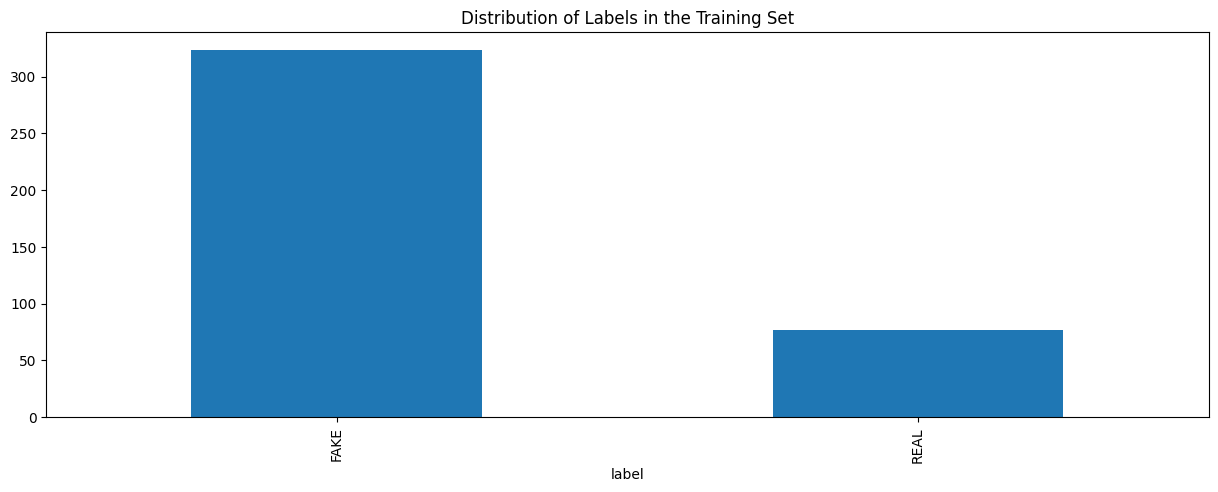

In [ ]:
train_sample_metadata.groupby('label')['label'].count().plot(figsize=(15, 5), kind='bar', title='Distribution of Labels in the Training Set')
plt.show()

In [ ]:
fake_train_sample_video = list(train_sample_metadata.loc[train_sample_metadata.label=='FAKE'].sample(3).index)
fake_train_sample_video

['aslsvlvpth.mp4', 'asmpfjfzif.mp4', 'dhoqofwoxa.mp4']

In [ ]:
real_train_sample_video = list(train_sample_metadata.loc[train_sample_metadata.label=='REAL'].sample(3).index)
real_train_sample_video

['ehtdtkmmli.mp4', 'aelfnikyqj.mp4', 'bddjdhzfze.mp4']

In [ ]:
def add_list_df(df, data):
    img_data = pd.DataFrame(data, columns=['path', 'label'])
    df1 = pd.concat([df, img_data], ignore_index=True)
    return df1

def convert_video_to_frames(df, dest_path):
    i = 0

    image_data = pd.DataFrame([], columns=['path', 'label'])
    os.makedirs(dest_path, exist_ok=True)


    for index, row in df.iterrows():
        i += 1
        filename = row['file']
        label = row['label']


        if max_videos > 0 and i > max_videos:
            return image_data;

        if filename.endswith('.mp4'):

            video = cv2.VideoCapture(filename)
            data = []

            file_key = filename.rsplit('/',1)[1][:-4]

            fdir = os.path.join(dest_path, file_key)

            if os.path.isdir(fdir):
                data = []
                img_count = 0

                for img_file in os.listdir(fdir):
                    img_count += 1
                    if img_file.endswith("jpg"):
                        data.append([os.path.join(fdir, img_file), label])

                image_data = add_list_df(image_data, data)

                if img_count != 0:
                    print(i, '.', img_count, "Frames found. Skipping", file_key, '\n')
                    continue

            os.makedirs(dest_path+file_key, exist_ok=True)



            fps = video.get(cv2.CAP_PROP_FPS)


            frame_interval = int(fps / n_frames)


            count = 0
            file_count = 1

            print(i, ". starting... ", file_key)

            while True:
                ret, frame = video.read()
                if not ret:
                    break
                if count % frame_interval == 0:

                    img_filename = f"{file_key}_{file_count:03d}.jpg"
                    img_path = os.path.join(dest_path, file_key, img_filename)


                    frame = get_nose_and_mouth(frame)
                    if frame is None:
                        continue

                    cv2.imwrite(img_path, frame)
                    data.append([img_path, label])


                    file_count += 1
                count += 1


            image_data = add_list_df(image_data, data)

            print("---- Frames saved. ", "\n")

            video.release()

    return image_data

In [ ]:

def startConvert():
    metadata = load_metadata()

    train_metadata, test_metadata = train_test_split(metadata, test_size=0.2,
                                                     stratify=metadata.loc[:, 'label'])
    train_metadata, val_metadata = train_test_split(train_metadata, test_size=0.2,
                                                    stratify=train_metadata.loc[:, 'label'])

    print("--- Train set conversion \n")
    train_data = convert_video_to_frames(train_metadata, train_frames_path )
    train_data.to_csv(frame_path+'train.csv', sep='\t', index=False)

    print("--- Test set conversion \n")
    test_data = convert_video_to_frames(test_metadata, test_frames_path)
    test_data.to_csv(frame_path+'test.csv', sep='\t', index=False)

    print("--- Validation set conversion \n")
    val_data = convert_video_to_frames(val_metadata, val_frames_path)
    val_data.to_csv(frame_path+'val.csv', sep='\t', index=False)


    print("Written to csv \n")

def getData():

    dtypes = dtypes = {'path': str, 'label': str}

    train_set = pd.read_csv(frame_path+'train.csv' , sep='\t', dtype=dtypes)
    test_set = pd.read_csv(frame_path+'test.csv', sep='\t', dtype=dtypes)
    val_set = pd.read_csv(frame_path+'val.csv', sep='\t', dtype=dtypes)

    return train_set, val_set, test_set

if not loadFromCSV:
    startConvert()

800 videos found
No duplicate videos found
Real :  477
Fake :  323 

--- Train set conversion 

1 . starting...  degpbqvcay
---- Frames saved.  

2 . starting...  cxfujlvsuw
---- Frames saved.  

3 . starting...  ystdtnetgj
---- Frames saved.  

4 . starting...  vmxfwxgdei
---- Frames saved.  

5 . starting...  kcjvhgvhpt
---- Frames saved.  

6 . starting...  igpvrfjdzc
---- Frames saved.  

7 . starting...  avibnnhwhp
---- Frames saved.  

8 . starting...  vjljdfopjg
---- Frames saved.  

9 . starting...  dxgnpnowgk
---- Frames saved.  

10 . starting...  oelqpetgwj
---- Frames saved.  

11 . starting...  oocincvedt
---- Frames saved.  

12 . starting...  cnilkgvfei
---- Frames saved.  

13 . starting...  bnjcdrfuov
---- Frames saved.  

14 . starting...  ehccixxzoe
---- Frames saved.  

15 . starting...  dtocdfbwca
---- Frames saved.  

16 . starting...  dhxctgyoqj
---- Frames saved.  

17 . starting...  ellavthztb
---- Frames saved.  

18 . starting...  eqslzbqfea
---- Frames saved

In [ ]:
train_set, validation_set, test_set = getData()

print("Train set : ", train_set.shape[0])
print("Validation set : ", validation_set.shape[0])
print("Test set : ", test_set.shape[0])

Train set :  2314
Validation set :  507
Test set :  605


In [ ]:
# Define the data generators
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

input_shape = (247, 163, 3)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_set,
    x_col='path',
    y_col='label',
    target_size=(247, 163),
    batch_size=32,
    class_mode='binary'
)

validation_generator = validation_datagen.flow_from_dataframe(
    dataframe=validation_set,
    x_col='path',
    y_col='label',
    target_size=(247, 163),
    batch_size=32,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_set,
    x_col='path',
    y_col='label',
    target_size=(247, 163),
    batch_size=32,
    class_mode='binary'
)

Found 2314 validated image filenames belonging to 2 classes.
Found 507 validated image filenames belonging to 2 classes.
Found 605 validated image filenames belonging to 2 classes.


In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model

def get_VGG_model(input_shape):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    for layer in base_model.layers:
        layer.trainable = False
    x = Flatten()(base_model.output)
    x = Dense(4096, activation='relu')(x)
    x = Dense(4096, activation='relu')(x)
    predictions = Dense(1, activation='sigmoid')(x)
    vgg_model = Model(inputs=base_model.input, outputs=predictions)
    vgg_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return vgg_model


Epoch 1/10
72/72 [==============================] - 18s 201ms/step - loss: 0.8953 - accuracy: 0.6030 - val_loss: 0.6351 - val_accuracy: 0.6979
Epoch 2/10
72/72 [==============================] - 19s 267ms/step - loss: 0.6494 - accuracy: 0.6543 - val_loss: 0.7176 - val_accuracy: 0.3417
Epoch 3/10
72/72 [==============================] - 16s 223ms/step - loss: 0.6546 - accuracy: 0.6415 - val_loss: 0.6716 - val_accuracy: 0.6396
Epoch 4/10
72/72 [==============================] - 18s 255ms/step - loss: 0.6687 - accuracy: 0.6437 - val_loss: 0.6158 - val_accuracy: 0.6979
Epoch 5/10
72/72 [==============================] - 16s 216ms/step - loss: 0.6447 - accuracy: 0.6503 - val_loss: 0.6102 - val_accuracy: 0.6917
Epoch 6/10
72/72 [==============================] - 14s 189ms/step - loss: 0.6519 - accuracy: 0.6503 - val_loss: 0.6123 - val_accuracy: 0.6958
Epoch 7/10
72/72 [==============================] - 14s 194ms/step - loss: 0.6309 - accuracy: 0.6648 - val_loss: 0.6102 - val_accuracy: 0.6938

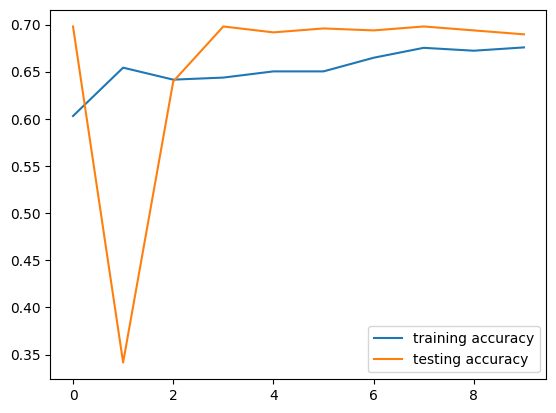

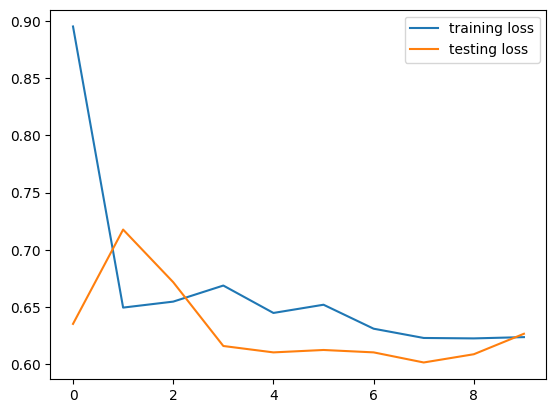

In [ ]:
vgg_model = get_VGG_model(input_shape)
test_model(vgg_model)

In [ ]:
model.save(root+"vgg_model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

def get_InceptionNet_model(input_shape):
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)
    for layer in base_model.layers:
        layer.trainable = False
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(1, activation='sigmoid')(x)
    Inception_model = Model(inputs=base_model.input, outputs=predictions)
    Inception_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return Inception_model


Epoch 1/10
72/72 [==============================] - 23s 241ms/step - loss: 0.7557 - accuracy: 0.7143 - val_loss: 0.4908 - val_accuracy: 0.7729
Epoch 2/10
72/72 [==============================] - 13s 182ms/step - loss: 0.3898 - accuracy: 0.8278 - val_loss: 0.5012 - val_accuracy: 0.7583
Epoch 3/10
72/72 [==============================] - 13s 180ms/step - loss: 0.3276 - accuracy: 0.8668 - val_loss: 0.4831 - val_accuracy: 0.7750
Epoch 4/10
72/72 [==============================] - 18s 250ms/step - loss: 0.3132 - accuracy: 0.8672 - val_loss: 0.4482 - val_accuracy: 0.8146
Epoch 5/10
72/72 [==============================] - 16s 219ms/step - loss: 0.2520 - accuracy: 0.9027 - val_loss: 0.6064 - val_accuracy: 0.7333
Epoch 6/10
72/72 [==============================] - 17s 240ms/step - loss: 0.2185 - accuracy: 0.9176 - val_loss: 0.4760 - val_accuracy: 0.7812
Epoch 7/10
72/72 [==============================] - 18s 245ms/step - loss: 0.1715 - accuracy: 0.9360 - val_loss: 0.5227 - val_accuracy: 0.7896

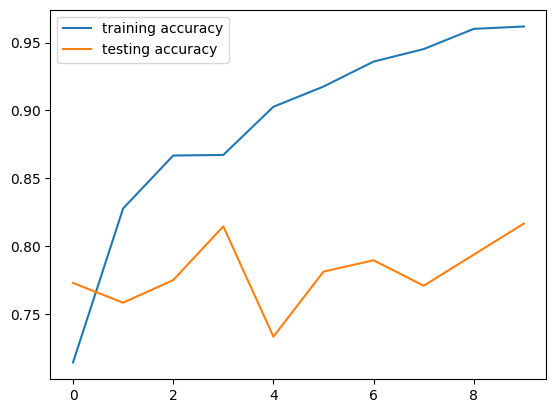

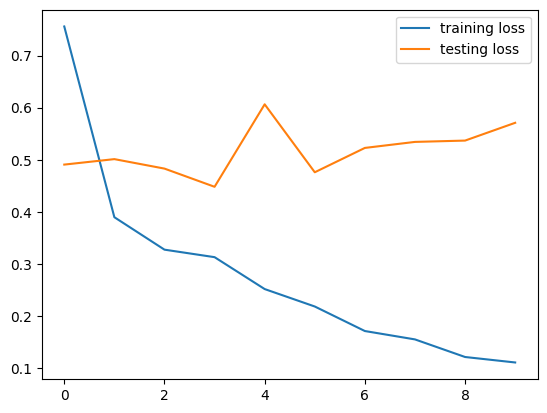

In [ ]:
InceptionNet_model = get_InceptionNet_model(input_shape)
test_model(InceptionNet_model)

In [ ]:
model.save(root+"InceptionNet_model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

def get_Xception_model(input_shape):
    base_model = Xception(weights='imagenet', include_top=False, input_shape=input_shape)
    for layer in base_model.layers:
        layer.trainable = False
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(1, activation='sigmoid')(x)
    Xception_model = Model(inputs=base_model.input, outputs=predictions)
    Xception_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return Xception_model


83683744/83683744 [==============================] - 5s 0us/step
Epoch 1/10
72/72 [==============================] - 26s 217ms/step - loss: 0.5580 - accuracy: 0.7344 - val_loss: 0.5112 - val_accuracy: 0.7646
Epoch 2/10
72/72 [==============================] - 14s 189ms/step - loss: 0.3864 - accuracy: 0.8269 - val_loss: 0.5314 - val_accuracy: 0.7521
Epoch 3/10
72/72 [==============================] - 13s 184ms/step - loss: 0.3160 - accuracy: 0.8602 - val_loss: 0.6003 - val_accuracy: 0.7646
Epoch 4/10
72/72 [==============================] - 13s 179ms/step - loss: 0.2661 - accuracy: 0.8909 - val_loss: 0.4828 - val_accuracy: 0.8146
Epoch 5/10
72/72 [==============================] - 16s 220ms/step - loss: 0.2598 - accuracy: 0.8904 - val_loss: 0.4571 - val_accuracy: 0.8125
Epoch 6/10
72/72 [==============================] - 13s 180ms/step - loss: 0.1791 - accuracy: 0.9308 - val_loss: 0.4278 - val_accuracy: 0.8271
Epoch 7/10
72/72 [==============================] - 13s 183ms/step - loss: 0.

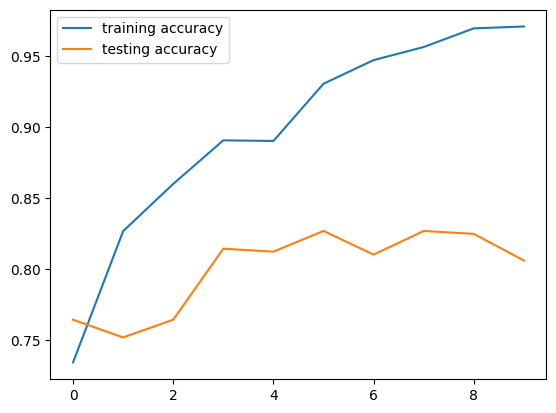

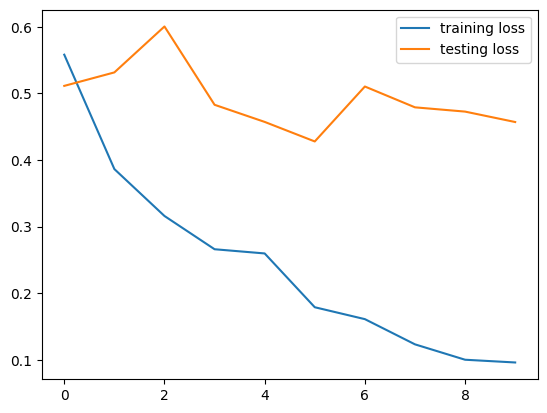

In [ ]:
Xception_model = get_Xception_model(input_shape)
test_model(Xception_model)

In [ ]:
model.save(root+"Xception_model.h5")

19/19 [==============================] - 3s 130ms/step


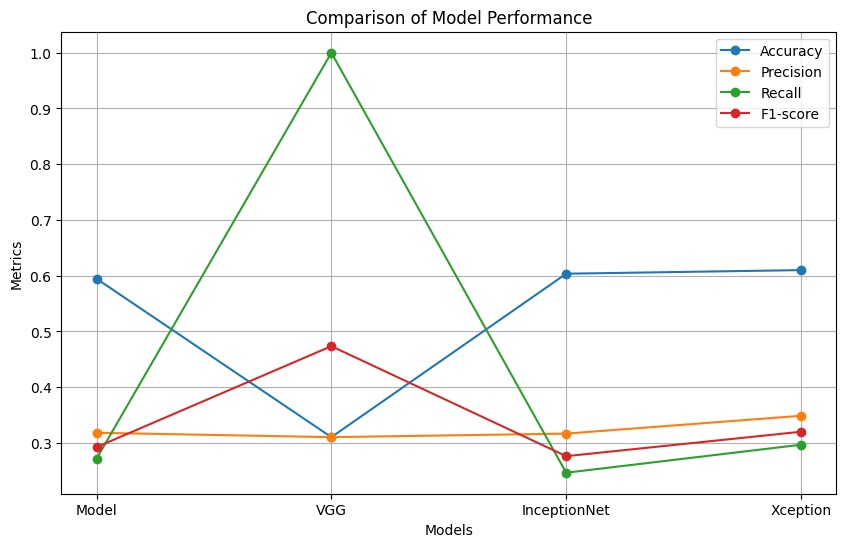

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

models = [model, vgg_model, InceptionNet_model, Xception_model]
model_names = ['Model', 'VGG', 'InceptionNet', 'Xception']
generators = [train_generator, validation_generator, test_generator]

metrics = {'Accuracy': [], 'Precision': [], 'Recall': [], 'F1-score': []}

for model in models:
    model_metrics = {'Accuracy': [], 'Precision': [], 'Recall': [], 'F1-score': []}
    for generator in generators:

        y_pred = model.predict(generator)
        y_true = generator.classes


        accuracy = accuracy_score(y_true, (y_pred > 0.5).astype(int))
        precision = precision_score(y_true, (y_pred > 0.5).astype(int))
        recall = recall_score(y_true, (y_pred > 0.5).astype(int))
        f1 = f1_score(y_true, (y_pred > 0.5).astype(int))

        model_metrics['Accuracy'].append(accuracy)
        model_metrics['Precision'].append(precision)
        model_metrics['Recall'].append(recall)
        model_metrics['F1-score'].append(f1)

    for metric in metrics.keys():
        metrics[metric].append(sum(model_metrics[metric]) / len(model_metrics[metric]))


plt.figure(figsize=(10, 6))
for metric in metrics.keys():
    plt.plot(model_names, metrics[metric], marker='o', label=metric)

plt.xlabel('Models')
plt.ylabel('Metrics')
plt.title('Comparison of Model Performance')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
print(len(model_names))
print(len(accuracies))


4
3


19/19 [==============================] - 3s 132ms/step


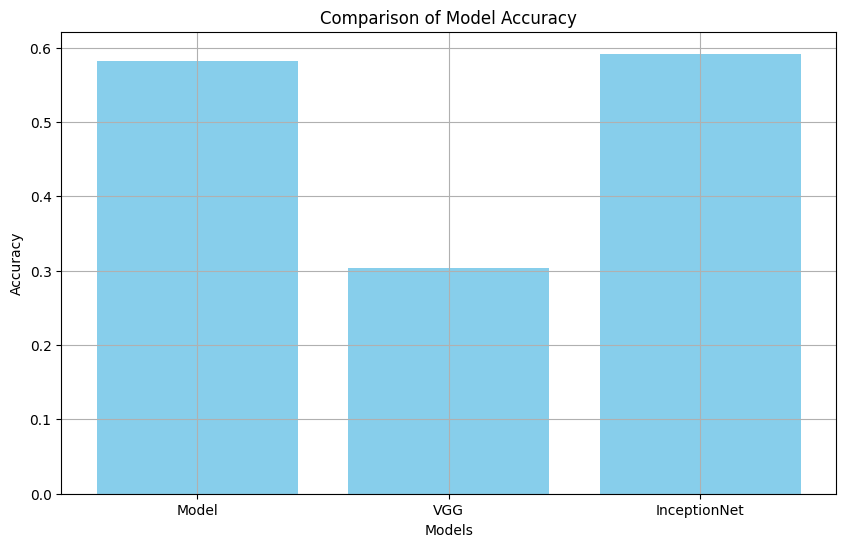

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score


models = [model, vgg_model, InceptionNet_model, Xception_model]
model_names = ['Model', 'VGG', 'InceptionNet', 'Xception']
generators = [train_generator, validation_generator, test_generator]

accuracies = []


for model, generator in zip(models, generators):
    y_pred = model.predict(generator)
    y_true = generator.classes
    accuracy = accuracy_score(y_true, (y_pred > 0.5).astype(int))
    accuracies.append(accuracy)


plt.figure(figsize=(10, 6))
plt.bar(model_names[:len(accuracies)], accuracies, color='skyblue')  # Use slicing to ensure model_names matches accuracies
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Comparison of Model Accuracy')
plt.grid(True)
plt.show()



In [ ]:
def get_DenseNet121_model(input_shape):

    densenet = DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape)

    for layer in densenet.layers:
        layer.trainable = False

    x = GlobalAveragePooling2D()(densenet.output)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=densenet.input, outputs=predictions)


    Densemodel.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

29084464/29084464 [==============================] - 0s 0us/step
Epoch 1/10
67/67 [==============================] - 502s 7s/step - loss: 0.5795 - accuracy: 0.7392 - val_loss: 0.4814 - val_accuracy: 0.7274
Epoch 2/10
67/67 [==============================] - 485s 7s/step - loss: 0.3650 - accuracy: 0.8396 - val_loss: 0.4799 - val_accuracy: 0.7413
Epoch 3/10
67/67 [==============================] - 426s 6s/step - loss: 0.3259 - accuracy: 0.8628 - val_loss: 0.5156 - val_accuracy: 0.7517
Epoch 4/10
67/67 [==============================] - 422s 6s/step - loss: 0.2886 - accuracy: 0.8812 - val_loss: 0.6148 - val_accuracy: 0.6962
Epoch 5/10
67/67 [==============================] - 478s 7s/step - loss: 0.3189 - accuracy: 0.8585 - val_loss: 0.4012 - val_accuracy: 0.8142
Epoch 6/10
67/67 [==============================] - 426s 6s/step - loss: 0.2353 - accuracy: 0.9035 - val_loss: 0.4130 - val_accuracy: 0.8142
Epoch 7/10
67/67 [==============================] - 426s 6s/step - loss: 0.2230 - accurac

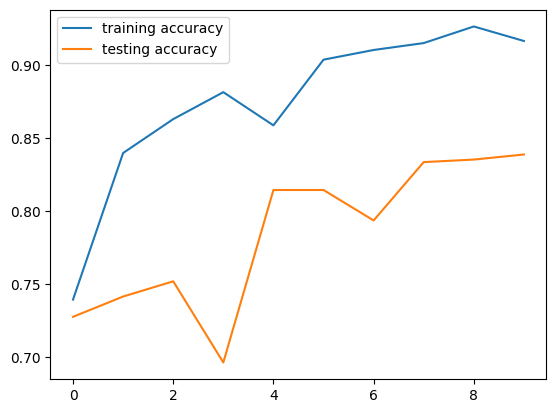

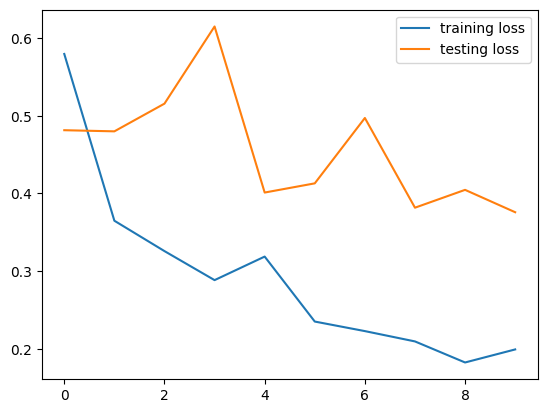

In [ ]:
model = get_DenseNet121_model(input_shape)
test_model(model)

In [ ]:
model.save(root+"densenet_model.h5")